<a href="https://www.kaggle.com/code/stemosamaghandour/jigsaw-agile-community-by-stemer-osama-geris?scriptVersionId=259673962" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-agile-community-rules/sample_submission.csv
/kaggle/input/jigsaw-agile-community-rules/train.csv
/kaggle/input/jigsaw-agile-community-rules/test.csv


In [7]:
# Split file into 1MB chunks
!split -b 1m kernel_source.bin kernel_part_

# Reassemble later
!cat kernel_part_* > reconstructed_kernel.bin

split: cannot open 'kernel_source.bin' for reading: No such file or directory
cat: 'kernel_part_*': No such file or directory


In [8]:
sample=pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/sample_submission.csv")
train_df = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/train.csv')
test_df = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/test.csv')


In [9]:
print(sample.columns)
print(train_df.columns)
print(test_df.columns)

Index(['row_id', 'rule_violation'], dtype='object')
Index(['row_id', 'body', 'rule', 'subreddit', 'positive_example_1',
       'positive_example_2', 'negative_example_1', 'negative_example_2',
       'rule_violation'],
      dtype='object')
Index(['row_id', 'body', 'rule', 'subreddit', 'positive_example_1',
       'positive_example_2', 'negative_example_1', 'negative_example_2'],
      dtype='object')


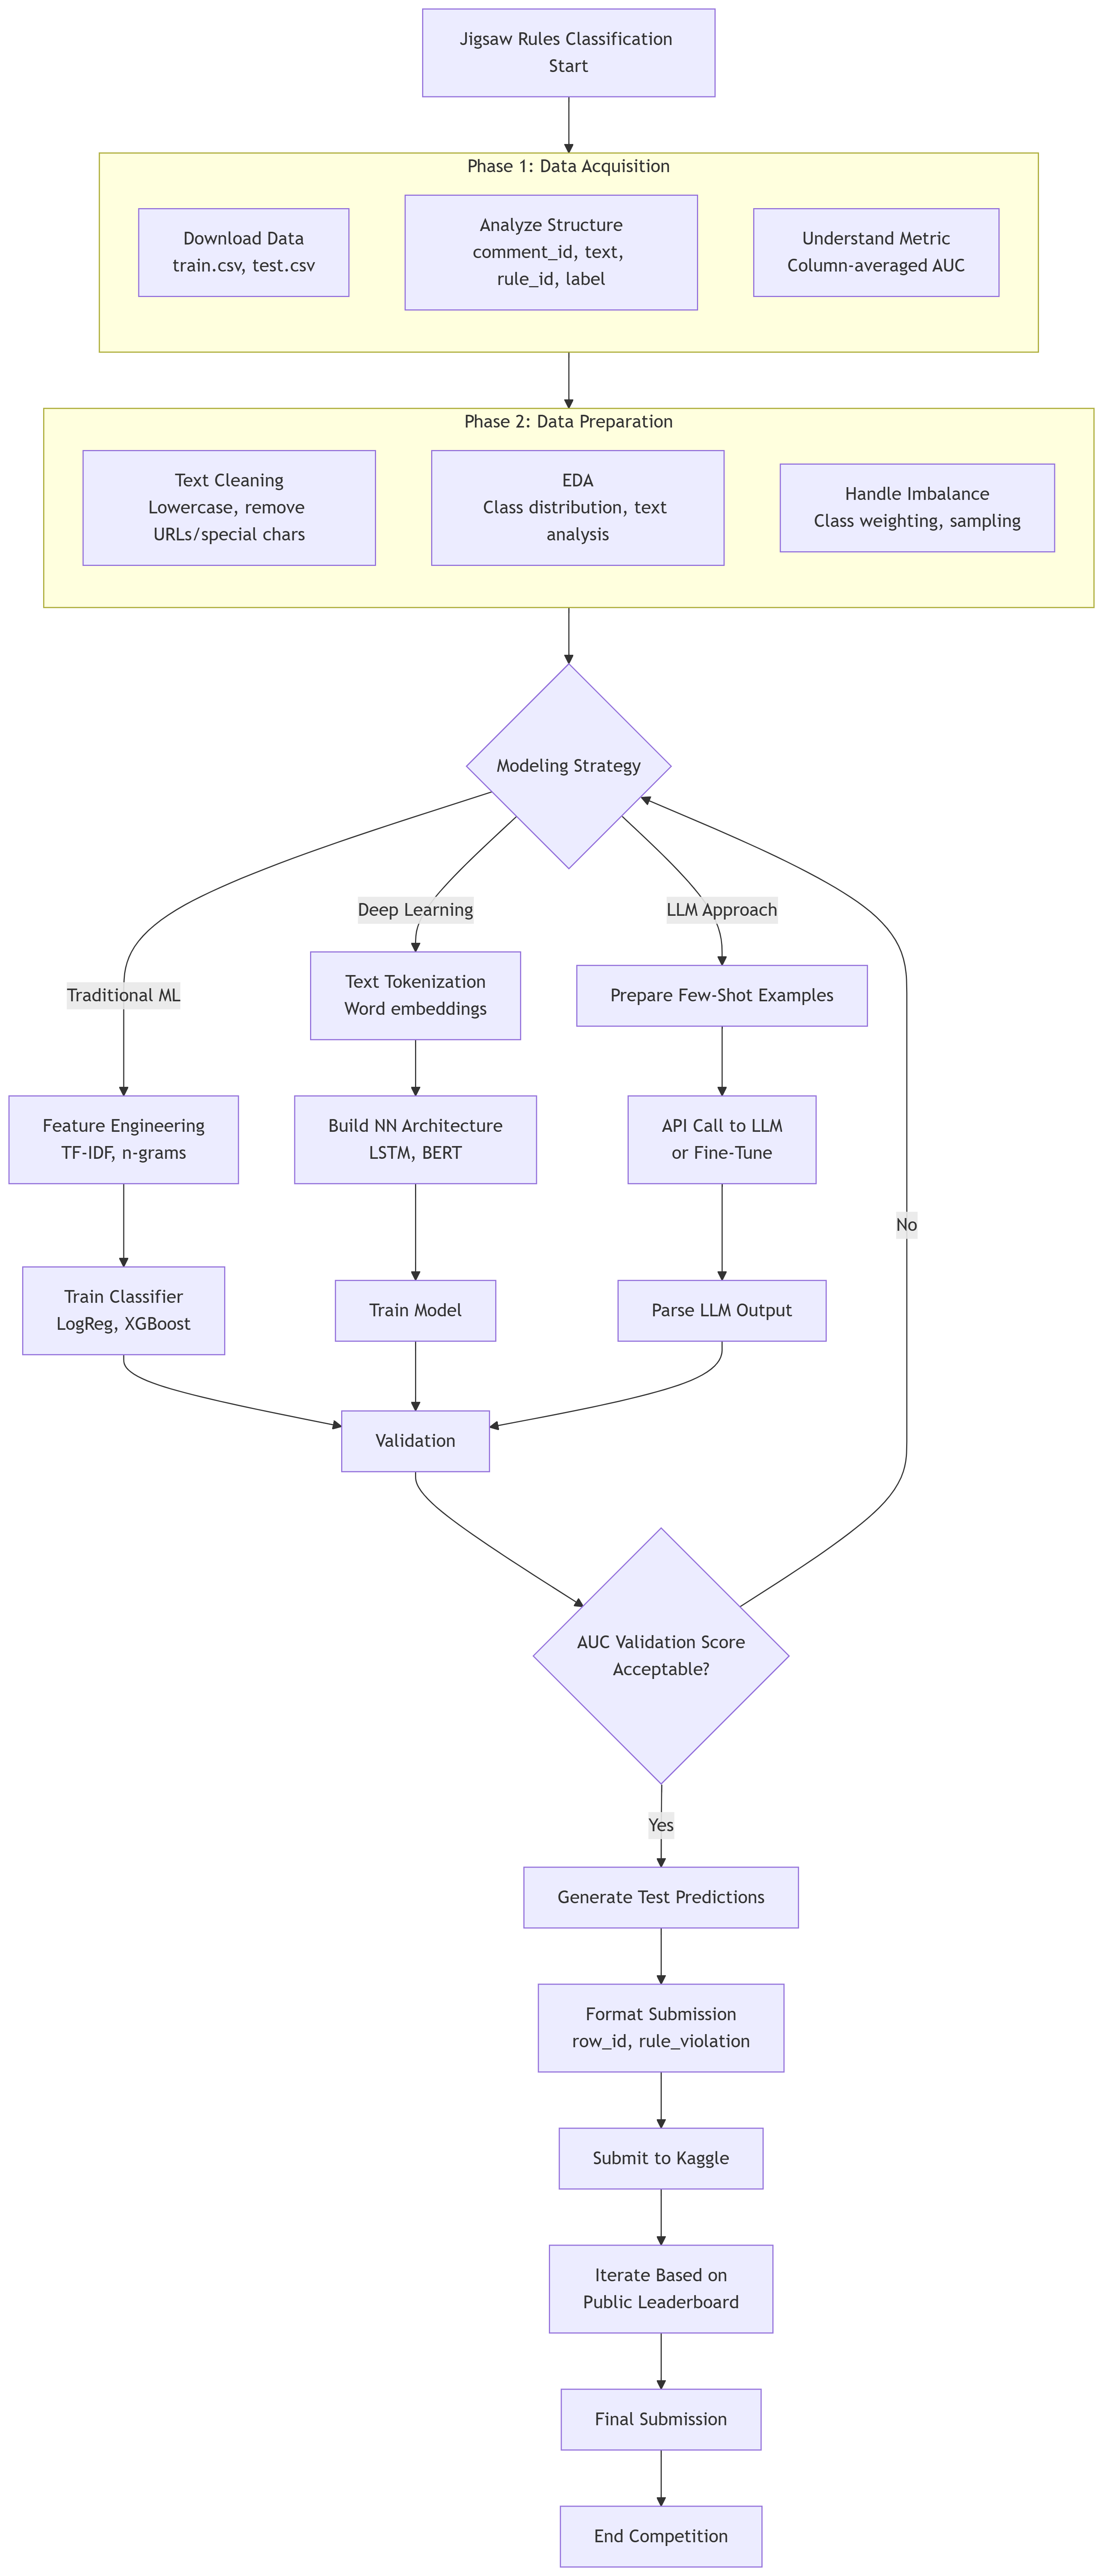

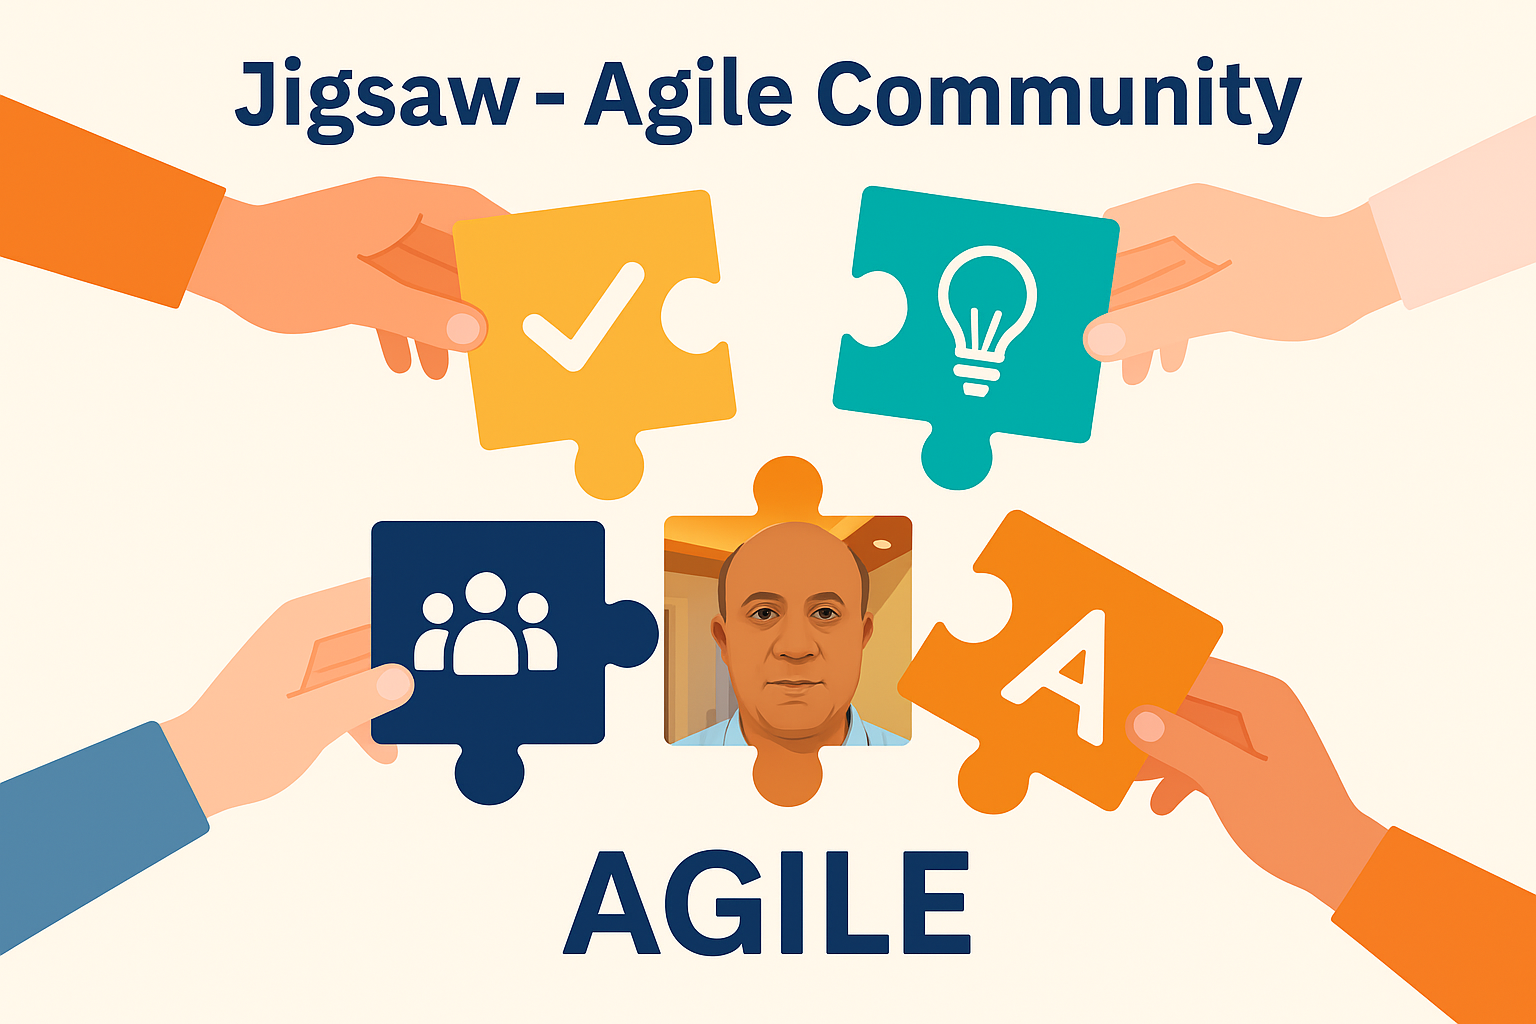

Key Steps Explained:
Understand Problem & Data

Goal: Predict if a comment violates a subreddit rule (binary classification).

Evaluation: Column-averaged AUC (focus on probabilistic outputs).

Data Exploration

Inspect columns: comment_text, rule_violation (binary label), subreddit.

Check for class imbalance (e.g., 90% "no violation" → need stratification).

Preprocess Text

Clean: Remove URLs, special characters, lowercase.

Vectorize:

TF-IDF for simple models (Logistic Regression).

BERT/RoBERTa for context-aware embeddings.

Feature Engineering

Add metadata features:

Comment length, sentiment (VADER), toxicity score (Detoxify).

Subreddit-specific flags (if subreddit ID is provided).

Model Selection

Baseline: Logistic Regression (interpretable, fast).

Advanced: Fine-tune BERT/RoBERTa (higher AUC but slower).

Evaluation & Tuning

Optimize for AUC (not accuracy!).

Address overfitting: Dropout, regularization, early stopping.

Submission

Format:

csv
row_id,rule_violation
2029,0.5
2030,0.67
Ensure probabilities (0–1) for each test sample.



In [10]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
import re
from urllib.request import urlopen
import requests

# 1. Data Loading with error handling
def load_data():
    try:
        train = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/train.csv')
        test = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/test.csv')
        print("Data loaded successfully")
        return train, test
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

# 2. Enhanced Feature Engineering without NLTK
def create_features(df):
    # Basic text features
    df['comment_length'] = df['body'].apply(lambda x: len(str(x)))
    df['word_count'] = df['body'].apply(lambda x: len(str(x).split()))
    
    # Simple sentiment analysis (alternative to VADER)
    def simple_sentiment(text):
        text = str(text).lower()
        positive_words = ['good', 'great', 'excellent', 'positive']
        negative_words = ['bad', 'poor', 'negative', 'awful']
        pos_count = sum(text.count(word) for word in positive_words)
        neg_count = sum(text.count(word) for word in negative_words)
        return (pos_count - neg_count) / max(len(text.split()), 1)
    
    df['sentiment'] = df['body'].apply(simple_sentiment)
    
    # Subreddit encoding
    df['subreddit_encoded'] = df['subreddit'].astype('category').cat.codes
    
    # Example similarity features
    def jaccard_similarity(text, example):
        if pd.isna(example) or str(example).strip() == '':
            return 0
        text_words = set(str(text).lower().split())
        example_words = set(str(example).lower().split())
        intersection = len(text_words & example_words)
        union = len(text_words | example_words)
        return intersection / union if union else 0
    
    example_cols = ['positive_example_1', 'positive_example_2', 
                   'negative_example_1', 'negative_example_2']
    for col in example_cols:
        if col in df.columns:
            df[f'sim_to_{col}'] = df.apply(lambda x: jaccard_similarity(x['body'], x[col]), axis=1)
    
    return df

# 3. Text Preprocessing
def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # URLs
    text = re.sub(r'[^\w\s]', ' ', text)  # Punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Extra spaces
    return text

# 4. Model Pipeline
def build_model():
    # Text processing
    text_features = Pipeline([
        ('tfidf', TfidfVectorizer(
            preprocessor=preprocess_text,
            max_features=10000,
            ngram_range=(1, 2),
            stop_words='english'
        ))
    ])
    
    # Numerical features
    numeric_features = Pipeline([
        ('scaler', StandardScaler())
    ])
    
    # Combine features
    preprocessor = ColumnTransformer([
        ('text', text_features, 'body'),
        ('num', numeric_features, ['comment_length', 'word_count', 'sentiment',
                                  'sim_to_positive_example_1', 'sim_to_positive_example_2',
                                  'sim_to_negative_example_1', 'sim_to_negative_example_2']),
        ('subreddit', 'passthrough', ['subreddit_encoded'])
    ])
    
    # Model with increased max_iter
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            class_weight='balanced',
            max_iter=2000,
            C=0.1,
            solver='liblinear',
            random_state=42
        ))
    ])
    
    return model

# 5. Training with cross-validation
def train_and_evaluate():
    train, test = load_data()
    if train is None:
        return None
    
    train = create_features(train)
    
    X = train.drop(['rule_violation', 'row_id'], axis=1, errors='ignore')
    y = train['rule_violation']
    
    # Stratified split for imbalanced data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    
    model = build_model()
    model.fit(X_train, y_train)
    
    val_preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, val_preds)
    print(f"\nValidation AUC: {auc:.4f}")
    
    # Show feature importance if possible
    if hasattr(model.named_steps['classifier'], 'coef_'):
        try:
            feature_names = (model.named_steps['preprocessor']
                           .named_transformers_['text']
                           .named_steps['tfidf']
                           .get_feature_names_out())
            print("\nTop 10 important features:")
            coef = model.named_steps['classifier'].coef_[0]
            top10 = np.argsort(-np.abs(coef))[:10]
            for i in top10:
                print(f"{feature_names[i]}: {coef[i]:.4f}")
        except Exception as e:
            print(f"\nCould not show feature importance: {e}")
    
    return model

# 6. Submission generation with checks
def generate_submission(model):
    if model is None:
        print("No model to generate submission")
        return
    
    _, test = load_data()
    if test is None:
        return
    
    test = create_features(test)
    
    # Handle missing columns
    required_cols = ['comment_length', 'word_count', 'sentiment', 'subreddit_encoded'] + \
                   [f'sim_to_{typ}_example_{i}' for typ in ['positive', 'negative'] for i in [1, 2]]
    
    for col in required_cols:
        if col not in test.columns:
            test[col] = 0
    
    try:
        test_preds = model.predict_proba(test[required_cols + ['body']])[:, 1]
        submission = pd.DataFrame({
            'row_id': test['row_id'],
            'rule_violation': test_preds
        })
        
        submission.to_csv('submission.csv', index=False)
        print("\nSubmission sample:")
        print(submission.head())
        print("\nSubmission stats:")
        print(submission['rule_violation'].describe())
    except Exception as e:
        print(f"Error generating submission: {e}")

if __name__ == '__main__':
    print("Starting training process...")
    trained_model = train_and_evaluate()
    
    if trained_model:
        print("\nGenerating submission file...")
        generate_submission(trained_model)
    print("Process completed")

Starting training process...
Data loaded successfully

Validation AUC: 0.7399

Top 10 important features:
stream: -0.5156
hd: -0.4446

Could not show feature importance: index 10001 is out of bounds for axis 0 with size 10000

Generating submission file...
Data loaded successfully

Submission sample:
   row_id  rule_violation
0    2029        0.361509
1    2030        0.539395
2    2031        0.552699
3    2032        0.393379
4    2033        0.485347

Submission stats:
count    10.000000
mean      0.423804
std       0.150855
min       0.112859
25%       0.359497
50%       0.406348
75%       0.525883
max       0.667599
Name: rule_violation, dtype: float64
Process completed


In [11]:
pip install IPython

Note: you may need to restart the kernel to use updated packages.


In [12]:
from IPython.display import display, Javascript

# Wait for IPython to load
display(Javascript('''
    function waitForIPython() {
        if (typeof Jupyter !== 'undefined') {
            Jupyter.notebook.clear_all_output();
        } else {
            setTimeout(waitForIPython, 100);
        }
    }
    waitForIPython();
'''))

<IPython.core.display.Javascript object>